## Notebook setup

In [ ]:
import os
import io
import warnings
import datetime
import numpy as np
import base64

import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

from IPython.display import HTML

# import sys
# sys.path.append('../../')

from openbb_terminal.api import widgets
from openbb_terminal.api import openbb
from openbb_terminal.helper_classes import TerminalStyle

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
warnings.filterwarnings("ignore")

# Detect if prediction capabilities are present. If they are not, disable prediction in the rest of the script
# so that the report can still be generated without prediction results.
# predictions = True
# try:
#     openbb.stocks.pred.models
# except Exception as e:
#     predictions = False

# TODO Fix predictions virtual path on api refactored

predictions = False

In [ ]:
try:
    theme = TerminalStyle("light", "light", "light")
except:
    pass
stylesheet = widgets.html_report_stylesheet()
with open("./openbb_terminal/reports/OpenBB_reports_logo.png", "rb") as image_file:
    openbb_image_encoded = base64.b64encode(image_file.read())

## Select symbol

In [ ]:
# Parameters that will be replaced when calling this notebook
symbol = "TSLA"
report_name = ""

In [ ]:
if "." in symbol:
    import sys

    sys.exit(0)

In [ ]:
ticker_data = openbb.stocks.load(
    symbol=symbol, start_date=datetime.datetime.now() - datetime.timedelta(days=4 * 30)
)
ticker_data = openbb.stocks.process_candle(df=ticker_data)

author = "Didier Rodrigues Lopes"
report_title = f"INVESTMENT RESEARCH REPORT ON {symbol.upper()}"
report_date = datetime.datetime.now().strftime("%d %B, %Y")
report_time = datetime.datetime.now().strftime("%H:%M")
report_timezone = datetime.datetime.now(datetime.timezone.utc).astimezone().tzinfo
report_title, report_date, report_time, report_timezone

In [ ]:
info = openbb.stocks.fa.info(symbol=symbol).transpose()

if info["Long business summary"][0] != "NA":
    overview = info["Long business summary"][0]
else:
    overview = info["Long name"][0]
overview

## Data

In [ ]:
(
    df_year_estimates,
    df_quarter_earnings,
    df_quarter_revenues,
) = openbb.stocks.dd.est(symbol=symbol)

In [ ]:
display_year = sorted(df_year_estimates.columns.tolist())[:3]
df_year_estimates = df_year_estimates[display_year].head(5)
df_year_estimates

In [ ]:
quote_data = openbb.stocks.quote(symbol)
quote_data

In [ ]:
df_quarter_revenues

In [ ]:
(
    df_major_holders,
    df_institutional_shareholders,
    df_mutualfund_shareholders,
) = openbb.stocks.fa.shrs(symbol)
df_institutional_shareholders.index += 1
df_institutional_shareholders

In [ ]:
df_sec_filings = openbb.stocks.dd.sec(symbol=symbol)[
    ["Type", "Category", "Link"]
].head(5)
df_sec_filings["Link"] = df_sec_filings["Link"].apply(
    lambda x: f'<a href="{x}">{x}</a>'
)
df_sec_filings

In [ ]:
df_analyst = openbb.stocks.dd.analyst(symbol=symbol)
if not df_analyst.empty:
    if "target" in df_analyst.columns:
        df_analyst["target_to"] = df_analyst["target_to"].combine_first(
            df_analyst["target"]
        )
    df_analyst = df_analyst[["category", "analyst", "rating", "target_to"]].rename(
        columns={
            "category": "Category",
            "analyst": "Analyst",
            "rating": "Rating",
            "target_to": "Price Target",
        }
    )
df_analyst

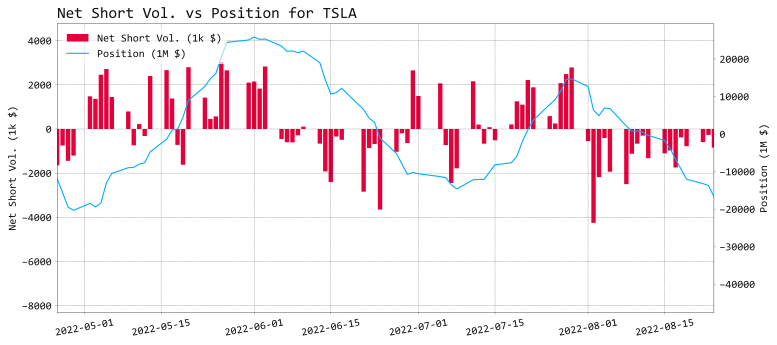

In [52]:
fig, ax1 = plt.subplots(figsize=(11, 5), dpi=150)
ax2 = ax1.twinx()
openbb.stocks.dps.spos(
    symbol=symbol,
    limit=84,
    raw=False,
    export="",
    external_axes=[ax1, ax2],
    chart=True,
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
net_short_position = f.getvalue().decode("utf-8")

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.dps.dpotc(
    symbol=symbol,
    external_axes=[ax1, ax2],
    chart=True
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
dark_pools = f.getvalue().decode("utf-8")

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
ax3 = ax1.twinx()
openbb.stocks.dps.psi_sg(
    symbol=symbol,
    external_axes=[ax1, ax2, ax3],
    chart=True,
)
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_vs_short_interest = f.getvalue().decode("utf-8")

In [ ]:
fig, (candles, volume) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.candle(
    symbol=symbol,
    data=ticker_data,
    use_matplotlib=True,
    external_axes=[candles, volume],
    chart=True,
)
candles.set_xticklabels("")
fig.tight_layout()

f = io.BytesIO()
fig.savefig(f, format="svg")
price_chart = f.getvalue().decode("utf-8")

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.pt(
    symbol=symbol,
    start_date="2022-01-01",
    data=ticker_data,
    limit=10,
    raw=False,
    external_axes=[ax],
    chart=True
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
price_target_chart = f.getvalue().decode("utf-8")

In [ ]:
df = openbb.stocks.dd.pt(symbol=symbol)
avg_ratings_last_30_days= 0
if not df.empty:
    avg_ratings_last_30_days = round(
        np.mean(
            df[datetime.datetime.now() - datetime.timedelta(days=30) :][
                "Price Target"
            ].values
        ),
        2,
    )
last_price = round(ticker_data["Close"][-1], 2)

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.dd.rot(
    symbol=symbol,
    limit=10,
    raw=False,
    export="",
    external_axes=[ax],
    chart=True
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ratings_over_time_chart = f.getvalue().decode("utf-8")

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 3), dpi=150)
openbb.common.ta.rsi(
    ticker_data["Close"], external_axes=[ax1, ax2], chart=True
)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
ta_rsi = f.getvalue().decode("utf-8")

In [ ]:
df = openbb.common.ta.rsi(ticker_data["Close"])
rsi_value = round(df.values[-1][0], 2)
rsi_value

In [ ]:
from sklearn.linear_model import LinearRegression

model = LinearRegression().fit(
    np.array(range(len(ticker_data["Close"][-30:].index))).reshape(-1, 1),
    ticker_data["Close"][-30:].values,
)
regression_slope = round(model.coef_[0], 2)

In [ ]:
import pandas as pd

df_insider = pd.DataFrame.from_dict(
    openbb.stocks.ins.lins(symbol=symbol)
).head(10)
df_insider["Val ($)"] = df_insider["Value ($)"].replace({",": ""}, regex=True)
df_insider["Trade"] = df_insider.apply(
    lambda row: (-1 * float(row["Val ($)"]))
    if row["Transaction"] == "Sale"
    else (float(row["Val ($)"]) if row["Transaction"] == "Buy" else 0),
    axis=1,
)
last_10_insider_trading = round(sum(df_insider["Trade"]) / 1_000_000, 2)
df_insider = df_insider.drop(columns=["Val ($)", "Trade"])
df_insider

In [ ]:
fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
openbb.stocks.ba.headlines(symbol=symbol, external_axes=[ax], chart=True)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
finbrain_sentiment = f.getvalue().decode("utf-8")

In [ ]:
df_sentiment_finbrain = openbb.stocks.ca.sentiment(
    symbols=[symbol]
)
finbrain_sentiment_val = float(df_sentiment_finbrain.values[-1][0])

In [ ]:
(
    watchlist_count,
    n_cases,
    n_bull,
    n_bear,
) = openbb.stocks.ba.bullbear(symbol=symbol)
stocktwits_sentiment = f"Watchlist count: {watchlist_count}</br>"
if n_cases > 0:
    stocktwits_sentiment += f"\nLast {n_cases} sentiment messages:</br>"
    stocktwits_sentiment += f"Bullish {round(100*n_bull/n_cases, 2)}%</br>"
    stocktwits_sentiment += f"Bearish {round(100*n_bear/n_cases, 2)}%"
else:
    stocktwits_sentiment += "No messages found"

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(11, 5), dpi=150)
openbb.stocks.ba.snews(symbol, external_axes=[ax1, ax2],chart=True)
fig.tight_layout()
f = io.BytesIO()
fig.savefig(f, format="svg")
snews = f.getvalue().decode("utf-8")

In [ ]:
ticker_data_all = openbb.stocks.load(
    symbol=symbol, start_date=datetime.datetime.now() - datetime.timedelta(days=5 * 12 * 21)
)
ticker_data_all["Returns"] = ticker_data_all["Adj Close"].pct_change()

In [ ]:
# Deprecated in the new API

# fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
# openbb.stocks.qa.bw(symbol, ticker_data_all, "Returns", False, external_axes=[ax])
# fig.tight_layout()
# f = io.BytesIO()
# fig.savefig(f, format="svg")
# bw_month = f.getvalue().decode("utf-8")

In [ ]:
# Deprecated in the new API

# fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
# openbb.stocks.qa.bw(symbol, ticker_data_all, "Returns", True, external_axes=[ax])
# fig.tight_layout()
# f = io.BytesIO()
# fig.savefig(f, format="svg")
# bw_year = f.getvalue().decode("utf-8")

In [ ]:
# TODO Fix predictions virtual path on api refactored

if predictions:
    regression_val = round(
        openbb.stocks.pred.models.regression.get_regression_model(
            ticker_data_all["Close"], 1, 80, 20, 1
        )[0][-1],
        2,
    )
    regression_val

In [ ]:
# TODO Fix predictions virtual path on api refactored

if predictions:
    fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
    openbb.stocks.pred.regression(
        symbol, ticker_data_all["Close"], 1, 80, 20, 1, external_axes=[ax]
    )
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    regression = f.getvalue().decode("utf-8")

In [ ]:
# TODO Fix predictions virtual path on api refactored

if predictions:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(11, 3), dpi=150)
    openbb.stocks.pred.mc(ticker_data["Close"], 30, 100, external_axes=[ax1, ax2])
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    mc = f.getvalue().decode("utf-8")

In [ ]:
# TODO Fix predictions virtual path on api refactored

if predictions:
    fig, ax = plt.subplots(figsize=(11, 3), dpi=150)
    openbb.stocks.pred.regression(
        symbol, ticker_data_all["Close"], 1, 80, 20, 1, external_axes=[ax]
    )
    fig.tight_layout()
    f = io.BytesIO()
    fig.savefig(f, format="svg")
    regression = f.getvalue().decode("utf-8")

## Render the report template to a file

In [ ]:
body = ""

img = f'<img src="data:image/png;base64,{openbb_image_encoded.decode()}" alt="OpenBB" style="width:144px;">'
body += widgets.header(
    img,
    author,
    report_date,
    report_time,
    report_timezone,
    f"<b>INVESTMENT RESEARCH REPORT:</b> {symbol}",
)

body += widgets.tablinks(
    [
        "Summary",
        "Overview",
        "Analyst Opinions",
        "Fundamental Analysis",
        "Dark Pool and Shorts",
        "Technical Analysis",
        "Insider Trading",
        "Behavioural Analysis",
        "Quantitative Analysis",
        "Prediction Techniques",
    ]
)

htmlcode = widgets.h(3, "KPIs")
htmlcode += widgets.kpi(
    [last_price],
    [
        "Last closing price is above the average price ratings of last 30 days",
        "Average price ratings of last 30 day is above last closing price",
    ],
    avg_ratings_last_30_days,
)
if predictions:
    htmlcode += widgets.kpi(
        [0],
        [
            "Regression (dollars per market day) on last 30 market days is negative",
            "Regression (dollars per market day) on last 30 market days is positive",
        ],
        regression_slope,
    )
htmlcode += widgets.kpi(
    [30, 70],
    ["RSI level is oversold", "RSI level is normal", "RSI level is overbought"],
    rsi_value,
)
htmlcode += widgets.kpi(
    [0],
    [
        "The sum of last 10 insider trading (in millions) was negative",
        "The sum of last 10 insider trading (in millions) was positive",
    ],
    last_10_insider_trading,
)
htmlcode += widgets.kpi(
    [-0.1, 0.1],
    [
        "Last FinBrain sentiment is bearish",
        " Last FinBrain sentiment is neutral",
        "Last FinBrain sentiment is bullish",
    ],
    finbrain_sentiment_val,
)
if predictions:
    htmlcode += widgets.kpi(
        [0],
        [
            "The regression for the next 20th market price is below closing price",
            "The regression for the next 20th market price is above closing price",
        ],
        round(regression_val - last_price, 2),
    )
body += widgets.add_tab("Summary", htmlcode)

htmlcode = widgets.row([widgets.h(3, "Price Chart") + price_chart])
htmlcode += widgets.row(
    [widgets.h(3, "Quote") + quote_data.to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Description") + widgets.p(overview)]
)
body += widgets.add_tab("Overview", htmlcode)

htmlcode = widgets.row([widgets.h(3, "Price Target Chart") + price_target_chart])
htmlcode += widgets.row([widgets.h(3, "Analyst Ratings over time") + ratings_over_time_chart])
htmlcode += widgets.row([widgets.h(3, "Analyst Ratings") + df_analyst.to_html()])
htmlcode += widgets.row([widgets.h(3, "Analyst Recommendations") + df_rating.to_html()])

body += widgets.add_tab("Analyst Opinions", htmlcode)

htmlcode = widgets.row(
    [widgets.h(3, "Estimates") + df_year_estimates.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Earnings") + df_quarter_earnings.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Revenues") + df_quarter_revenues.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "Major Institutional Shareholders") + df_institutional_shareholders.head().to_html()]
)
htmlcode += widgets.row(
    [widgets.h(3, "SEC filings") + df_sec_filings.to_html(escape=False)]
)
body += widgets.add_tab("Fundamental Analysis", htmlcode)

htmlcode = widgets.row([net_short_position])
htmlcode += widgets.row([price_vs_short_interest])
htmlcode += widgets.row([dark_pools])
body += widgets.add_tab("Dark Pool and Shorts", htmlcode)

body += widgets.add_tab("Technical Analysis", widgets.row([ta_rsi]))

htmlcode = widgets.row(
    [
        widgets.h(3, "Last Activity")
        + df_insider.head(10).to_html(col_space="75px")
    ]
)
body += widgets.add_tab("Insider Trading", htmlcode)

htmlcode = widgets.row([finbrain_sentiment])
htmlcode += widgets.row([snews])
htmlcode += widgets.row(
    [widgets.h(3, "Stocktwits") + stocktwits_sentiment]
)
body += widgets.add_tab("Behavioural Analysis", htmlcode)

# Deprecated in the new API
htmlcode = widgets.row([bw_month])
htmlcode += widgets.row([bw_year])
body += widgets.add_tab("Quantitative Analysis", htmlcode)

if predictions:
    htmlcode = widgets.row([regression])
    htmlcode += widgets.row([mc])
else:
    htmlcode = widgets.row(["Prediction features not enabled."])
body += widgets.add_tab("Prediction Techniques", htmlcode)

body += widgets.tab_clickable_evt()

report = widgets.html_report(title=report_name, stylesheet=stylesheet, body=body)

# to save the results
with open(report_name + ".html", "w", encoding="utf-8") as fh:
    fh.write(report)